In [19]:
import chess.pgn
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry_convert
from geopy.geocoders import Nominatim
import folium
import cartopy.crs as ccrs
from tqdm import tqdm

In [1196]:
pgn = open("caissabase.pgn") # DB containing ~4 million chess games

In [321]:
# VISUALIZATION 1----------------------------------------------------HEATMAP OF LETHAL ZONES
kill_moves = []    # store killing moves (containing 'x')
death_squares = [] # store square positions where captures occured

# parse 500 games
for i in range(0, 250):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    # loop through all moves in this game
    for move in game.mainline_moves(): 
        if 'x' in board.san(move): # if this is a capturing move, append to kill_moves
            kill_moves.append(board.san(move))
        board.push(move) # next move

In [322]:
# Here I find the capture position for each capture move.
# The 2-character position always follows after the 'x', 
# so one can generalize and obtain it by concatenating
# the characters at [index(x)+1] and [index(x)+2]
for elem in kill_moves:
    xi = elem.index('x') # find index for 'x'
    death_squares.append(elem[xi + 1] + elem[xi + 2]) # get position and append to list

# get capture occurrences for each square and store them in a dictionary
dic = collections.Counter(death_squares)
# sort keys alphabetically and numerically (a1,a2,...,h7,h8)
dic = collections.OrderedDict(sorted(dic.items()))

In [323]:
chessboard = np.array(list(dic.values()) ).reshape(8,8) # transform to 2D numpy array
chessboard = chessboard.transpose() # transpose (swap rows with columns)
chessboard = np.flipud(chessboard)  # flip vertically to match chessboard layout

In [324]:
# convert numpy array to dataframe for easier use with seaborn
df = pd.DataFrame(data=chessboard, 
                  index=["8", "7", "6", "5", "4", "3", "2", "1"], 
                  columns=["a", "b", "c", "d", "e", "f", "g", "h"])

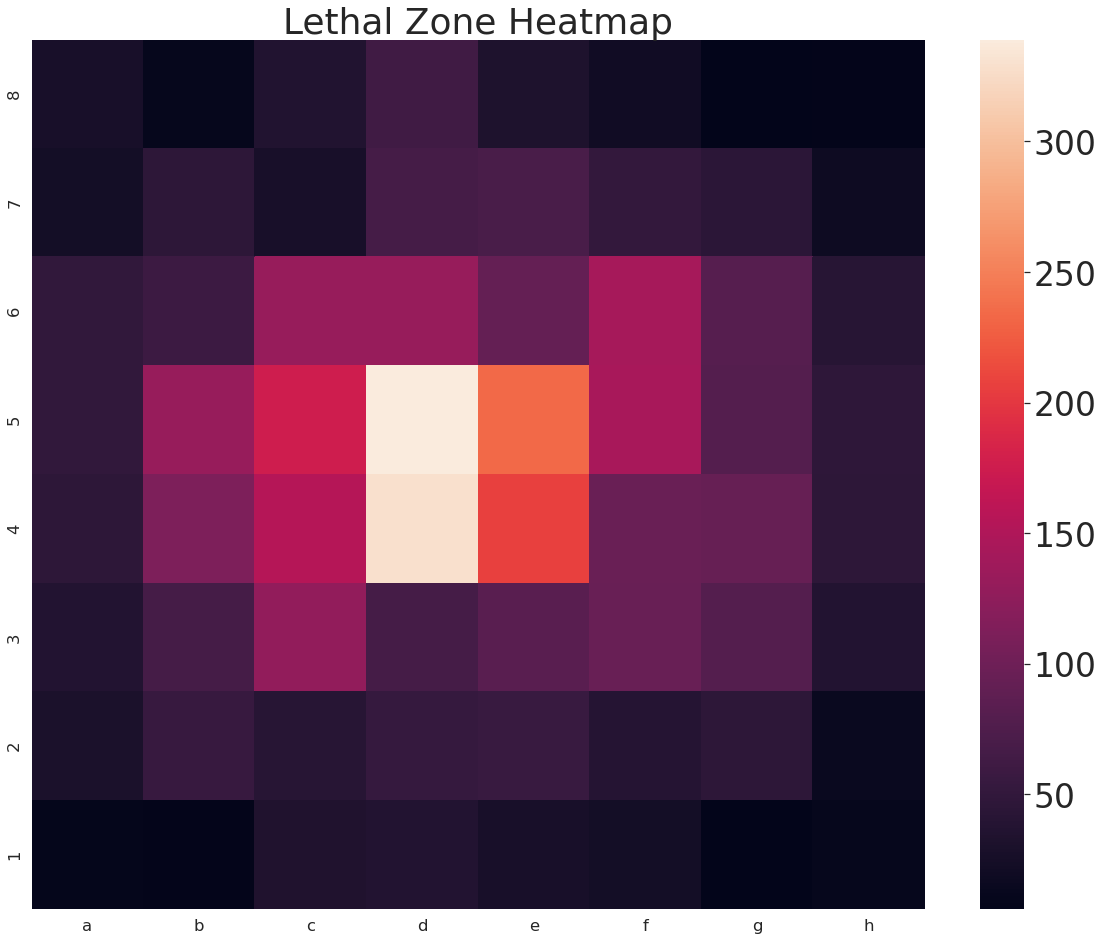

In [325]:
# configure and plot heatmap
fig, ax = plt.subplots(figsize=(20,16))
sns.set(font_scale = 3)
ax.set_title('Lethal Zone Heatmap')
ax = sns.heatmap(df, linewidths=0)
plt.savefig('fig/heatmap.png')
plt.show()

In [942]:
# VISUALIZATION 2-------------------------------------------------PIECE LETHALITY BAR CHART

# Pieces doing the capturing are stored in this list. Contains uppercase characters 
# denoting captures executed by {'K'ings,'Q'ueens,'R'ooks, K'nights,'B'ishops}. 
# Also contains lower case characters, all denoting captures executed by pawns.
capturing_pieces_loose_pawns = [] 

# extract capturing piece type
for elem in kill_moves:
    capturing_pieces_loose_pawns.append(elem[0][0])
    
pawncaps = 0 # get number of captures executed by pawns
for i in range(len(capturing_pieces_loose_pawns)):
    if capturing_pieces_loose_pawns[i].islower():
        pawncaps += 1
        
# populate new list with only uppercase characters i.e. excluding pawn data
capturing_pieces = [x for x in capturing_pieces_loose_pawns if x.isupper()]       
        
# get occurrences for each piece except pawns and store them in a dictionary
captures = collections.Counter(capturing_pieces)
captures["P"] = pawncaps # add single key-value pair for all captures executed by pawns
captures

Counter({'B': 819, 'Q': 649, 'N': 801, 'R': 835, 'K': 208, 'P': 1337})

In [1132]:
# convert dict to numpy array
temp = np.array(list(captures.values()) )
# convert numpy array to dataframe for easier use with seaborn
captures_df = pd.DataFrame(data=temp, 
                  columns=["Captures"], 
                  index=["Bishop", "Queen", "Knight", "Rook", "King", "Pawn"])

captures_df = captures_df.transpose()
captures_df

array([ 819,  649,  801,  835,  208, 1337])

In [328]:
# The number of captures a piece is able to make is dependent on how many pieces there are.
# To normalize, I divide each capture score by the number of pieces for each piece type.
captures_df.at["Captures", "Bishop"] = captures_df.at["Captures", "Bishop"] / 2
captures_df.at["Captures", "Knight"] = captures_df.at["Captures", "Knight"] / 2
captures_df.at["Captures", "Rook"] = captures_df.at["Captures", "Rook"] / 2
captures_df.at["Captures", "Pawn"] = captures_df.at["Captures", "Pawn"] / 8

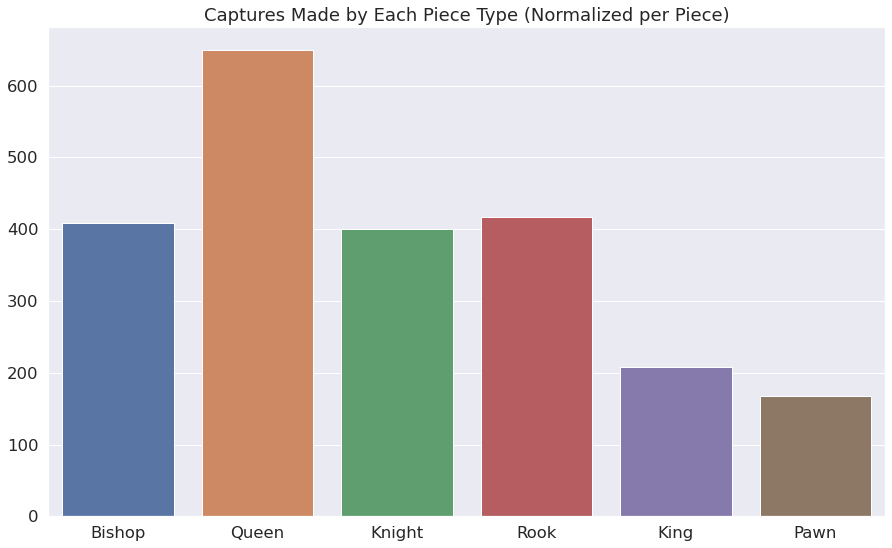

In [362]:
# configure and plot bar chart
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Captures Made by Each Piece Type (Normalized per Piece)')
sns.set(font_scale = 1.5)
ax1 = sns.barplot(data=captures_df)
plt.savefig('fig/barplot.png')
plt.show()

In [1039]:
# VISUALIZATION 3---------------------------------------QUEEN LETHALITY VS WINS SCATTER PLOT

wins_offsets = []
win_pattern = r"[1]-[0]|[0]-[1]"
white_win_pattern = r"[1]-[0]"
black_win_pattern = r"[0]-[1]"

# skim through headers
for i in range(0,10000):
    offset = pgn.tell()
    headers = chess.pgn.read_headers(pgn)
    
    if headers is None:
        break
    
    # if this game was won by white (white game)
    if re.match(win_pattern, headers.get("Result")):
        wins_offsets.append(offset)

In [1040]:
white_move = True
black_move = True
wins = 0

white_queen_captures_in_white_wins = []
black_queen_captures_in_black_wins = []

# for each win (black and white)
for offset in wins_offsets:
    pgn.seek(offset)
    headers = chess.pgn.read_headers(pgn)
    
    # if this is a white win
    if re.match(white_win_pattern, headers.get("Result")):
        game = chess.pgn.read_game(pgn)
        board = game.board()
        wqueencaps = 0        
        # check all moves in game
        for move in game.mainline_moves():  
            # if move is a white queen capturing a piece
            if white_move is True and 'Qx' in board.san(move):
                wqueencaps += 1
                white_move = False
                board.push(move)
            else:
                white_move = True
                board.push(move)
        
    # append white queen captures and increment wins
    white_queen_captures_in_white_wins.append(wqueencaps)
    wins += 1
    
    # if this is a black win
    if re.match(black_win_pattern, headers.get("Result")):
        game = chess.pgn.read_game(pgn)
        board = game.board()
        bqueencaps = 0   
        # check all moves in game
        for move in game.mainline_moves():     
            # if move is a black queen capturing a piece
            if black_move is True and 'Qx' in board.san(move):
                bqueencaps += 1
                black_move = False
                board.push(move)
            else:
                black_move = True
                board.push(move)
                
    # append black queen captures and increment wins
    black_queen_captures_in_black_wins.append(bqueencaps)
    wins += 1

In [1041]:
# join the 2 lists to get all queen captures made by the winner in every non-tied game
queen_captures_by_winner = white_queen_captures_in_white_wins + black_queen_captures_in_black_wins

In [1042]:
queen_captures_by_winner.sort()
test = collections.Counter(queen_captures_by_winner)
test

Counter({0: 1459,
         1: 3907,
         2: 4097,
         3: 2406,
         4: 1185,
         5: 646,
         6: 212,
         7: 79,
         8: 47,
         9: 15,
         10: 5,
         12: 2})

In [1043]:
df = pd.Series(test).to_frame("H")
df.H

0     1459
1     3907
2     4097
3     2406
4     1185
5      646
6      212
7       79
8       47
9       15
10       5
12       2
Name: H, dtype: int64

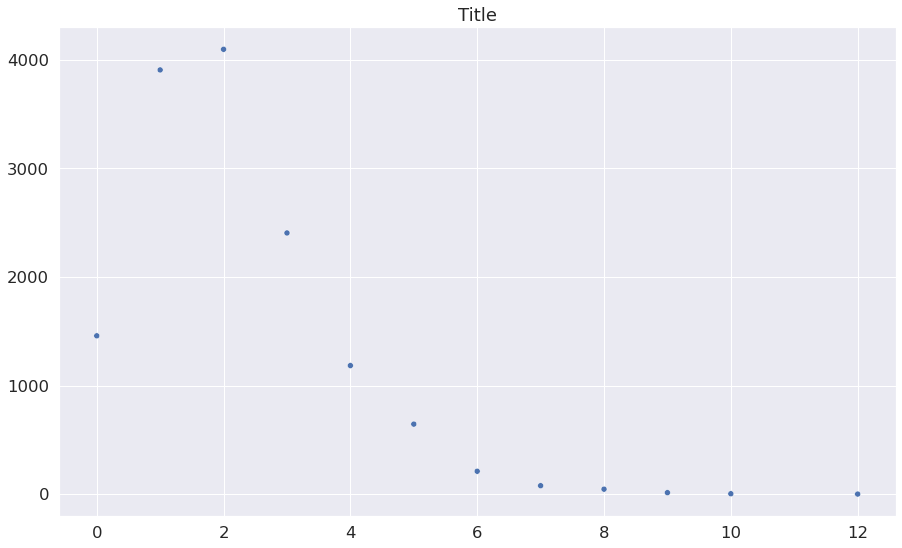

In [1044]:
# configure and plot scatter plot
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Title')
sns.set(font_scale = 1.5)
ax = sns.scatterplot(data=df, legend=False)
# plt.savefig('fig/scatter.png')
plt.show()




In [27]:
moves = {}
for i in range(0,100000):
    game_length = np.random.randint(100)
    try:
        moves[str(game_length)] += 1
    except:
        moves.update({str(game_length): 1})

sum(moves.values())


100000

In [ ]:
# VISUALIZATION 4---------------------------------------------------NUMBER OF MOVES PER GAME
moves = {}
pbar = tqdm(total=4000000)

while True:
    # read in game
    game = chess.pgn.read_game(pgn)
    
    # if reached end of pgn file
    if game is None:
        break
    
    board = game.board()
    game_length = 0
    
    # loop through all moves in this game
    for move in game.mainline_moves():
        game_length += 1
        board.push(move)
    
    try: # populate moves dictionary   
        moves[str(game_length)] += 1
    except: # if no previous game with same number of moves, create new entry
        moves.update({str(game_length): 1})
    
    pbar.update(1) # update progress bar
    
pbar.close() # close progress bar

# configure and plot bar chart
fig, ax = plt.subplots(figsize=(20,14), dpi=800)
ax.set_title('Frequencies of Game Length in Moves')
sns.set(font_scale = 1.5)
plt.hist(game_lengths, bins=len(game_lengths), color="blue", edgecolor='blue')
plt.savefig('fig/moves_histogram.png')
plt.show()

3626it [03:24, 17.70it/s]0000 [00:13<13:07:14, 84.66it/s]
 95%|█████████▍| 3790074/4000000 [11:34:39<39:39, 88.22it/s]   error during pgn parsing
Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/__init__.py", line 2932, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/pgn.py", line 1651, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/pgn.py", line 1032, in parse_san
    return board.parse_san(san)
  File "/home/quentin/anaconda3/envs/cps3235/lib/python3.7/site-packages/chess/__init__.py", line 2934, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen

{}

In [1156]:
game_lengths


[17,
 20,
 20,
 21,
 21,
 22,
 26,
 34,
 37,
 39,
 40,
 42,
 42,
 42,
 43,
 43,
 45,
 46,
 47,
 47,
 47,
 48,
 48,
 48,
 48,
 48,
 49,
 49,
 49,
 50,
 50,
 51,
 51,
 51,
 52,
 52,
 53,
 53,
 53,
 53,
 53,
 55,
 56,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 58,
 59,
 60,
 60,
 60,
 61,
 61,
 61,
 61,
 62,
 62,
 63,
 63,
 63,
 64,
 64,
 65,
 65,
 65,
 65,
 68,
 68,
 68,
 68,
 68,
 69,
 69,
 69,
 70,
 71,
 71,
 71,
 72,
 73,
 73,
 73,
 73,
 73,
 73,
 74,
 74,
 74,
 74,
 74,
 74,
 75,
 75,
 75,
 75,
 76,
 76,
 76,
 76,
 77,
 77,
 77,
 77,
 78,
 78,
 78,
 78,
 78,
 79,
 79,
 79,
 79,
 79,
 79,
 80,
 80,
 81,
 81,
 81,
 82,
 83,
 83,
 83,
 83,
 83,
 84,
 84,
 84,
 84,
 84,
 85,
 85,
 85,
 86,
 86,
 87,
 87,
 87,
 87,
 88,
 88,
 88,
 89,
 90,
 90,
 90,
 90,
 90,
 91,
 91,
 91,
 92,
 92,
 93,
 93,
 93,
 93,
 93,
 94,
 95,
 95,
 96,
 96,
 96,
 96,
 96,
 97,
 97,
 98,
 98,
 98,
 98,
 99,
 99,
 100,
 100,
 100,
 101,
 101,
 101,
 101,
 101,
 101,
 101,
 102,
 102,
 102,
 102,
 103,
 103,
 104,
 104,
 1

In [1150]:
# x = []
# y = []
# for k in dic.keys():
#     x.append(k)
# for v in dic.values():
#     y.append(v)
    
# plt.bar(x, y, color="blue")
# plt.show()
# sns.distplot(x)

In [691]:
# VISUALIZATION 5--------------------------------------------GEO MAP OF CHESS GAME LOCATIONS

locations = []
regex = r"\b[A-Z]{3}\b"
res = re.compile(regex)

# skim through headers
for i in range(0,10000):
    offset = pgn.tell()
    headers = chess.pgn.read_headers(pgn)
    
    if headers is None:
        break 
        
    # append alpha 3 country code to locations list
    locations.append(res.findall(headers.get("Site")))

# flatten list of lists to 1D list
flat_list = [item for sublist in locations for item in sublist]

In [692]:
# adapted from https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
def a3_get_continent(a3):
    try:
        a2_code = pycountry_convert.country_alpha3_to_country_alpha2(a3)
    except:
        if a3 == "GER": return a3_get_continent("DEU")
        if a3 == "NED": return a3_get_continent("NLD")   
        if a3 == "POR": return a3_get_continent("PRT")
        if a3 == "SCO": return a3_get_continent("GBR")
        if a3 == "ENG": return a3_get_continent("GBR")
        if a3 == "IRE": return a3_get_continent("GBR")
        a2_code = "Unknown"
    try:
        continent = pycountry_convert.country_alpha2_to_continent_code(a2_code)
    except:
        continent = "Unknown"
    
    return(a2_code, continent)

In [693]:
country_continent = []
for i in flat_list:
    country_continent.append(a3_get_continent(i))
    
    
d = collections.Counter(country_continent)
d = collections.OrderedDict(sorted(d.items()))

In [694]:
s = pd.Series(d)
geo_df = pd.DataFrame(d.items(), columns=["Location", "Games"])

In [695]:
# adapted from https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
geolocator = Nominatim(user_agent="myGeocoder")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [697]:
country_coords = []
for i in range(len(geo_df.Location)):
    country_coords.append(geolocate(geo_df.Location[i][0]))

lats = []
longs = []
for coord in country_coords:
    if(isinstance(coord, float) is False):
        lats.append(coord[0])
        longs.append(coord[1])
    else:
        lats.append(28.644800)
        longs.append(77.216721)

geo_df["Latitude"] = lats
geo_df["Longitude"] = longs

In [700]:
# remove all unknown countries/games
for i in range(len(geo_df)):
    if (geo_df.iloc[i][0][0] == "Unknown"):
        geo_df = geo_df.drop(index=i)

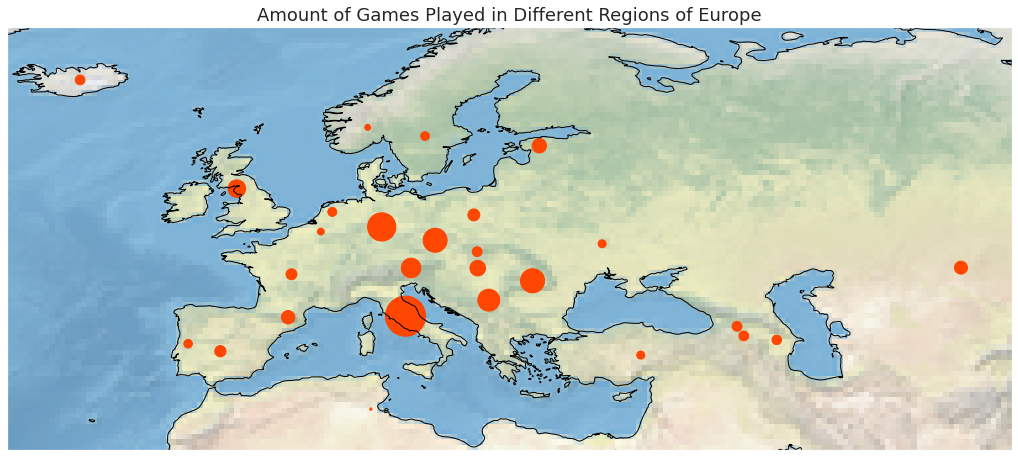

In [755]:
# set up and plot Europe map
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# closeup of Europe
ax.set_extent([-25, 70, 30, 70], crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines(resolution = '50m')

plt.scatter(x=geo_df.Longitude, y=geo_df.Latitude,
            color="orangered",
            s=geo_df.Games,
            alpha=0.99)
plt.title("Amount of Games Played in Different Regions of Europe")
plt.show()

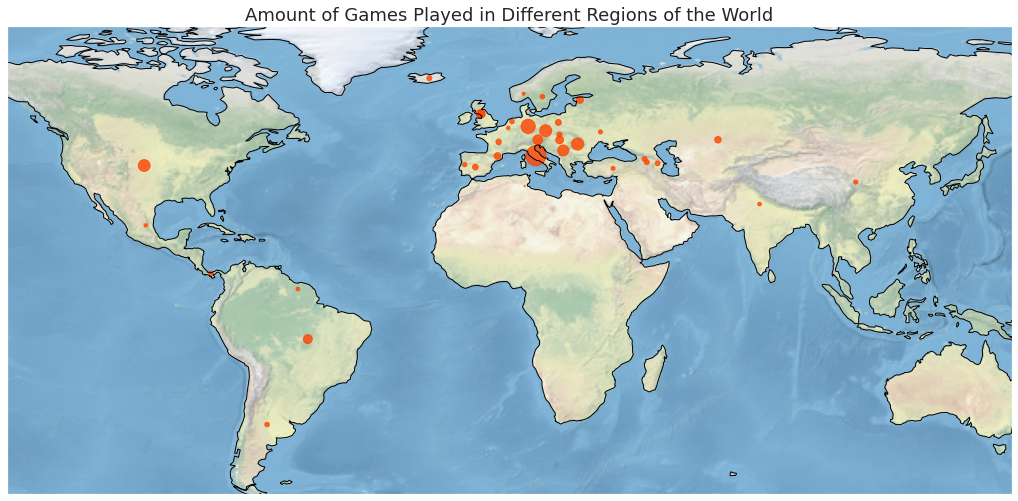

In [757]:
# set up and plot world map
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# full map of the world
ax.set_extent([-140, 150, -55, 80], crs=ccrs.PlateCarree()) 

ax.stock_img()
ax.coastlines()

plt.scatter(x=geo_df.Longitude, y=geo_df.Latitude,
            color="orangered",
            s=geo_df.Games / 4,
            alpha=0.8)
plt.title("Amount of Games Played in Different Regions of the World")
plt.show()

In [6]:
# code doodling...
wgames_offsets = []
bgames_offsets = []
wgames = []         # stores games won by whites 
bgames = []         # stores games won by blacks

# skim through headers based on some condition
# without parsing entire games
for i in range(0,100):
    offset = pgn.tell()
    headers = chess.pgn.read_headers(pgn)
    
    if headers is None:
        break

    if headers["Result"][0] == '1': # white win
        wgames_offsets.append(offset)
        
    if headers["Result"][0] == '0': # black win
        bgames_offsets.append(offset)

# parse white games
for offset in wgames_offsets:
    pgn.seek(offset)
    wgames.append(chess.pgn.read_game(pgn))

# parse black games
for offset in bgames_offsets:
    pgn.seek(offset)
    bgames.append(chess.pgn.read_game(pgn))

In [49]:
kill_moves = [] # stores all killing moves

for g in range(len(wgames)):
    board = wgames[g].board()
    
    for move in wgames[g].mainline_moves():
        if 'x' in board.san(move):
            kill_moves.append(board.san(move))
        board.push(move)

kill_moves


['fxg6',
 'hxg6',
 'Bxd4',
 'cxd4',
 'Nxf3+',
 'Bxf3',
 'cxd5',
 'exd5',
 'fxe5',
 'Rxg5',
 'Nxd4',
 'Bxd4',
 'cxd4',
 'Qxd4',
 'exf5',
 'gxf5',
 'Nxf3+',
 'Bxf3',
 'Bxg7',
 'Qxg7',
 'Nxe5',
 'Qxb2',
 'Nxb2',
 'Nxf4',
 'Rxg4',
 'hxg4',
 'Nxg4',
 'axb5',
 'axb5',
 'Nxh6',
 'Kxh6',
 'Rxf6+',
 'Rxf6',
 'gxf6',
 'Bxb5',
 'Kxf6',
 'Rxb7',
 'Bxf3',
 'Bxh7',
 'Nxg3',
 'hxg3',
 'bxc5',
 'dxc5',
 'dxe6',
 'Bxe6',
 'gxf5',
 'Bxf5',
 'Bxf5',
 'Qxf5',
 'Nxb4',
 'cxb4',
 'Qxb4',
 'Rxf3',
 'gxf3',
 'fxg4',
 'Qxg4+',
 'Bxe7',
 'Qxe7',
 'cxd5',
 'exd5',
 'dxe4',
 'Nxe4',
 'Nxe4',
 'Bxe4',
 'Bxd5',
 'Rxd5',
 'Rxd5',
 'Rxd5',
 'cxd5',
 'Rxd5',
 'Rxd5',
 'Qxd5',
 'cxd5',
 'cxd4',
 'dxe6',
 'Bxe6',
 'Qxd4',
 'Bxd2+',
 'Nbxd2',
 'Qxb2',
 'Nxf3+',
 'Nxf3',
 'Qxe2',
 'Nxe2',
 'Bxa4',
 'Rxb7',
 'hxg4',
 'hxg4',
 'Nxg4+',
 'Rxg4',
 'Bxf5',
 'Rxg5+',
 'Rxa6',
 'Rxa6',
 'Bxa6',
 'Rxa3',
 'Nxd4',
 'Bxd4',
 'Bxd7+',
 'Qxd7',
 'axb5',
 'axb5',
 'Rxa8',
 'Rxa8',
 'fxg6',
 'hxg6',
 'Qxd7',
 'Nxd7',
 'dxe5',
 'Nxe5',
